In [1]:
import os
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from cfmining.mip_builder import RecourseBuilder
from cfmining.action_set import ActionSet

from cfmining.algorithms import MAPOCAM, BruteForce, Greedy
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier, GeneralClassifier
from cfmining.visualization import buildTable, FeatureImportance, PlotCounterfactuals

/home/everton/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

## Probability threshold

In [3]:
prob = 0.82

# Read in the data

In [4]:
data_dir = "data/"
data_name = 'german'
data_file = os.path.join(data_dir, '%s_processed.csv' % data_name)
## load and process data
german_df = pd.read_csv(data_file).reset_index(drop=True)
german_df = (german_df
             .assign(isMale=lambda df: (df['Gender']=='Male').astype(int))
             .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
            )

y = german_df['GoodCustomer']
X = german_df.drop('GoodCustomer', axis=1)

In [5]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=100, random_state=2500)

# Train model

In [6]:
## grid search
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
grid = GridSearchCV(
  clf, param_grid={'C': np.logspace(-10, 10, num=25)},
  cv=5,
  scoring='roc_auc'
)
grid.fit(Xtr, ytr)
clf = grid.best_estimator_

/home/everton/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/everton/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [8]:
print('AUC performance:', roc_auc_score(yts, clf.predict(Xts)))

AUC performance: 0.6668928086838535


## Preparing classifiers to be actionable

In [9]:
clf_logreg_ = MonotoneClassifier(clf, Xtr, ytr, threshold=prob)
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]

## Preparing action set

In [10]:
action_set = ActionSet(X = X)
action_set.embed_linear_clf(coefficients=coefficients)

for feat in action_set:
    if feat.name in ['LoanDuration']:
        feat.step_type ="absolute"
        feat.step_size = 6
        feat.update_grid()
    else:
        feat.step_type ="relative"
        feat.step_size = 0.1
    feat.update_grid()

for feat in action_set:
    if feat.name in ['Age', 'Single', 'JobClassIsSkilled', 'ForeignWorker', 'OwnsHouse', 'RentsHouse', 'isMale', 'Age', 'LoanDuration', 'LoanAmount']:
        feat.mutable = False
        #feat.flip_direction = 1
        #feat.step_direction = 1
    if feat.name in ['LoanRateAsPercentOfIncome', 'NumberOfOtherLoansAtBank', 'MissedPayments',
                     'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'RentsHouse', 'Unemployed', 'YearsAtCurrentJob_lt_1']:
        feat.mutable = True
        #feat.flip_direction = -1
        #feat.step_direction = -1
    if feat.name in ['YearsAtCurrentHome', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
                     'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
                     'NoCurrentLoan', 'HasCoapplicant', 'HasGuarantor', 'OwnsHouse', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled']:
        feat.mutable = True
        #feat.flip_direction = 1
        #feat.step_direction = 1
    feat.update_grid()

## Preparing sample to be actionable

In [11]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
denied_individuals = scores.loc[lambda s: s < 0.75].index

In [13]:
124 in denied_individuals

True

In [16]:
#choice = np.random.choice(denied_individuals)
choice = 124
individual = X.loc[choice].values

In [17]:
clf.predict_proba([individual])

/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.65721732, 0.34278268]])

## Preparing criterias

In [18]:
percCalc = PercentileCalculator(action_set=action_set)
percCriteria = PercentileCriterion(individual, percCalc)
percChCriteria = PercentileChangesCriterion(individual, percCalc)

## Generate original counterfactual

In [19]:
p = prob
rb = RecourseBuilder(
      optimizer="cplex",
      coefficients=coefficients,
      intercept=intercept- (np.log(p / (1. - p))),
      action_set=action_set,
      x=np.array(individual)
)

build_info, indices = rb._get_mip_build_info()
output_1 = rb.fit()

In [20]:
print('Number of actions', sum(output_1['actions']!=0))
(pd.Series(output_1['actions'], index=X.columns).to_frame('Actions')).replace(0,'-')

Number of actions 4


Actions
ForeignWorker                         -
Single                                -
Age                                   -
LoanDuration                          -
LoanAmount                            -
LoanRateAsPercentOfIncome             -
YearsAtCurrentHome                    -
NumberOfOtherLoansAtBank              -
NumberOfLiableIndividuals             -
HasTelephone                          -
CheckingAccountBalance_geq_0          -
CheckingAccountBalance_geq_200      1.0
SavingsAccountBalance_geq_100       1.0
SavingsAccountBalance_geq_500       1.0
MissedPayments                        -
NoCurrentLoan                         -
CriticalAccountOrLoansElsewhere       -
OtherLoansAtBank                      -
HasCoapplicant                        -
HasGuarantor                        1.0
OwnsHouse                             -
RentsHouse                            -
Unemployed                            -
YearsAtCurrentJob_lt_1                -
YearsAtCurrentJob_geq_4               -
JobClassIsSkilled                     -
isMale                                -

## Enumerate counterfactuals

In [21]:
en_nd_feat = MAPOCAM(action_set, individual, clf_logreg_, max_changes=3, recursive=True, clean_suboptimal=False)
start = time.perf_counter()
en_nd_feat.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.04495191599926329


/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-pack

## Counterfactual summary

In [22]:
names = action_set.df['name'].values
overview_clean = buildTable(en_nd_feat, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_feat, individual, percCriteria, names, include_original=True, include_cost=True)

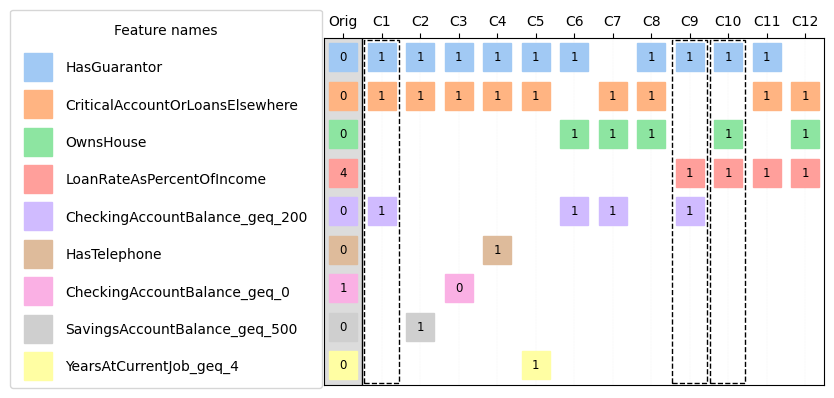

In [23]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show('plot/feature_nondom_enum.pdf', hl_column=[1, 9, 10], bbox_to_anchor=(-0.004, -0.01))

## Brute force

In [24]:
start = time.perf_counter()
en_bf_feat = BruteForce(action_set, individual, clf_logreg_, max_changes=3, clean_suboptimal=True)
en_bf_feat.fit()
brute_time = time.perf_counter()-start
print('Elapsed time:', brute_time)

Elapsed time: 0.0926497760010534


/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-pack

In [25]:
names = action_set.df['name'].values
overview_clean = buildTable(en_bf_feat, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_bf_feat, individual, percCriteria, names, include_original=True, include_cost=True)

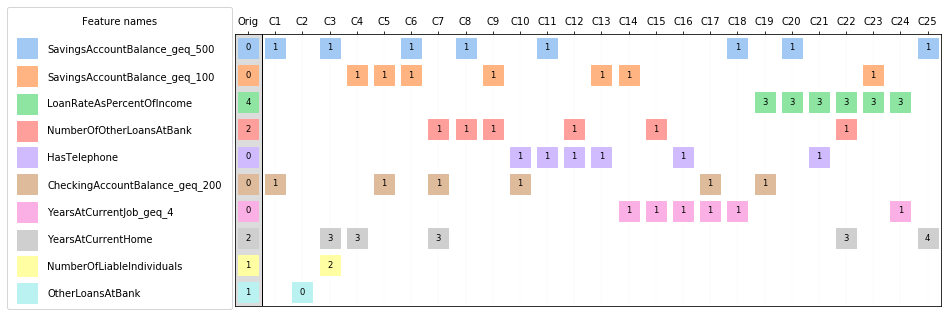

In [22]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:25], individual)
pltW.show('plot/feature_nondom_bf.pdf', bbox_to_anchor=(-0.004, -0.01))

## Another non-dominate criterion

In [26]:
en_nd_pc = MAPOCAM(action_set, individual, clf_logreg_, max_changes=5, compare=percChCriteria)
start = time.perf_counter()
en_nd_pc.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.07924099000047136


/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-pack

In [27]:
names = action_set.df['name'].values
overview_clean = buildTable(en_nd_pc, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_pc, individual, percCriteria, names, include_original=True, include_cost=True)

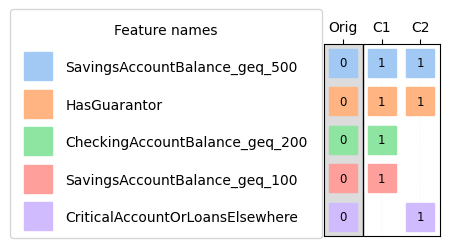

In [28]:
pltW = PlotCounterfactuals(overview_clean, individual)
pltW.show('plot/pc_nondom_enum.pdf', bbox_to_anchor=(-0.02, -0.01))

## Brute force

In [29]:
en_bf_pc = BruteForce(action_set, individual, clf_logreg_, max_changes=5, compare=percChCriteria)
start = time.perf_counter()
en_bf_pc.fit()
print('Elapsed time:', time.perf_counter()-start)

/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-pack

Elapsed time: 0.9737003939990245


/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/everton/.local/lib/python3.10/site-pack

In [30]:
names = action_set.df['name'].values
overview_clean = buildTable(en_bf_pc, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_bf_pc, individual, percCriteria, names, include_original=True, include_cost=True)

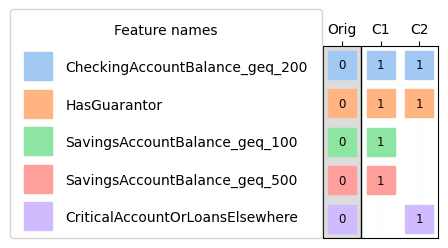

In [31]:
pltW = PlotCounterfactuals(overview_clean, individual)
pltW.show('plot/pc_nondom_bf.pdf')